# walkthrough of an vine copula (vinecop) application on financial (US ETFs) dependence modeling and simulation.

- data preprocessing and exploratory data analysis
- make marginal cdf/ppf, transform from raw return to copula data
- fit 'rvine', draw, do full simulation
- fit 'cvine', draw, do cond simulation (given **SPY** scenario)


## initialization, fetch data, preprocess


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yfinance as yf

import torchvinecopulib as tvc

lst_ticker = [
    "SPY",
    "QQQ",
    "DIA",
    "IJH",
    "VTI",
    "IWM",
    "XLF",
    "XLE",
    "XLK",
    "EFA",
    "EWA",
    "EWJ",
    "EEM",
    "FXI",
    "AGG",
    "TLT",
    "GLD",
    "SLV",
    "USO",
    "UNG",
]
print(lst_ticker)
raw_df = yf.download(lst_ticker, start="2010-01-01")
raw_df.index = pd.DatetimeIndex(raw_df.index)
raw_df = raw_df["Adj Close"].ffill()
# calc simple retn
NUM_DAY_INTVL = 1
df_retn_adjclose_simple_last_intvl = np.expm1(np.log(raw_df)[::NUM_DAY_INTVL].diff(1).dropna())
#
NUM_SIM = 50000
print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

['SPY', 'QQQ', 'DIA', 'IJH', 'VTI', 'IWM', 'XLF', 'XLE', 'XLK', 'EFA', 'EWA', 'EWJ', 'EEM', 'FXI', 'AGG', 'TLT', 'GLD', 'SLV', 'USO', 'UNG']


[*********************100%%**********************]  20 of 20 completed

cuda (GPU) avail? True



### chart rolling bidep between each asset and SPY


In [2]:
f_bidep = lambda a, b: tvc.util.kendall_tau(a, b)[0]
dct_dep_spy = {}
for df in df_retn_adjclose_simple_last_intvl.rolling(
    window=252 // NUM_DAY_INTVL, step=int(np.sqrt(252) // NUM_DAY_INTVL)
):
    if df.shape[0] >= 252 // NUM_DAY_INTVL:
        dct_dep_spy[df.index[-1]] = {
            k: f_bidep(torch.from_numpy(df[[k]].values), torch.from_numpy(df[["SPY"]].values))
            for k in df.keys()
        }

Text(0.5, 1.0, 'Rolling bivariate dependence (<lambda>), between ETFs and SPY.')

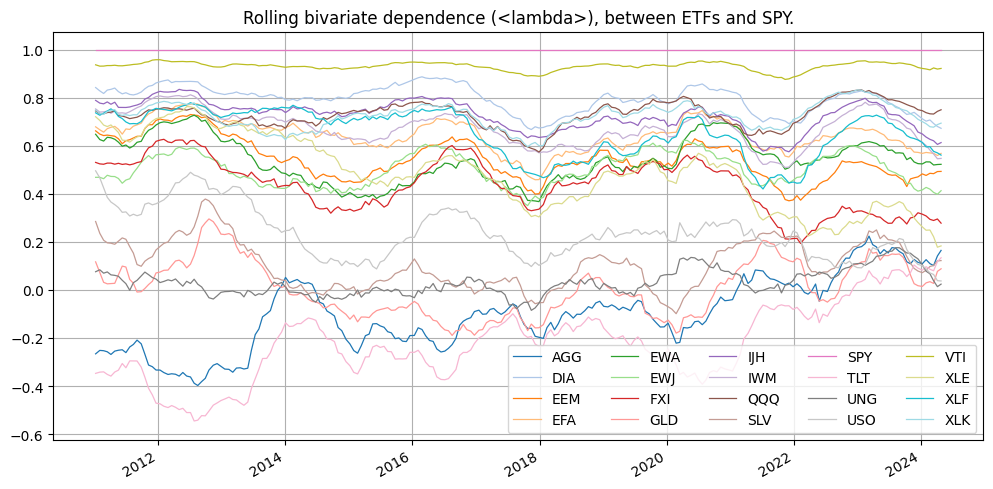

In [3]:
pd.DataFrame(dct_dep_spy).T.plot(figsize=(12, 6), style="-", alpha=1, lw=0.9, colormap="tab20")
plt.legend(ncol=5)
plt.grid()
plt.title(f"Rolling bivariate dependence ({f_bidep.__name__}), between ETFs and SPY.")

### make marginal cdf_ppf functions; transform from raw data (-∞,∞)-> copula data (0,1)


In [4]:
from scipy import stats
from random import seed as r_seed
from scipy.special import ndtr
from scipy.interpolate import CubicSpline


def make_cdf_ppf(
    vec_obs: np.array,
    mtd_margin: str,
    seed: int,
    lst_distribution: list = [
        stats.t,
        stats.nct,
        stats.johnsonsu,
        stats.tukeylambda,
    ],
) -> pd.Series:
    """fit marginal univariate distributions, return fitted cdf/ppf functions
    # ! band_width for np fit from:
    Dhaker, H., Deme, E. H., & Ciss, Y. (2021).
    β-Divergence loss for the kernel density estimation with bias reduced.
    Statistical Theory and Related Fields, 5(3), 221-231.
    """
    r_seed(seed)
    np.random.seed(seed=seed)
    vec_clean = np.sort(vec_obs[np.isfinite(vec_obs)])
    if mtd_margin == "np":
        # The constant has beta = 1.7320508075688772 from
        # (4 * beta**4 / (9 * beta**4 - 36 * beta**3 + 90 * beta**2 + 270 * beta + 105) * sqrt(2 / pi))**(1 / 9)
        band_width = vec_clean.std() * 0.6973425390765554 * (len(vec_clean)) ** (-1 / 9)

        # empirical cdf, semi parametric approach, from mixture
        @np.vectorize
        def res_cdf(quantile: np.array):
            # ±∞ return to (0,1) cdf
            return ndtr((quantile - vec_clean) / band_width).mean()

        vec_F, idx = np.unique(res_cdf(vec_clean), return_index=True)
        func_spline = CubicSpline(x=vec_F, y=vec_clean[idx])

        def res_ppf(percentage: np.array):
            # (0,1) cdf to ±∞ return
            return func_spline(percentage)

    elif mtd_margin == "p":
        dist, par, bic2, lnn2 = None, None, np.inf, np.log(len(vec_clean)) / 2
        for iter_dist in lst_distribution:
            iter_par = iter_dist.fit(vec_clean)
            iter_bic2 = len(iter_par) * lnn2 - iter_dist.logpdf(vec_clean, *iter_par).sum()
            if iter_bic2 < bic2:
                dist, par, bic2 = iter_dist, iter_par, iter_bic2
        res_cdf, res_ppf = lambda vec: dist.cdf(vec, *par), lambda vec: dist.ppf(vec, *par)

    return pd.Series({"cdf": res_cdf, "ppf": res_ppf})

In [5]:
arr_cdf_ppf = np.apply_along_axis(
    func1d=lambda vec: make_cdf_ppf(vec_obs=vec, mtd_margin="np", seed=0),
    axis=0,
    arr=df_retn_adjclose_simple_last_intvl.values,
)

In [6]:
V_mvcp = torch.as_tensor(
    np.hstack(
        [
            cdf(df_retn_adjclose_simple_last_intvl.values[:, [idx]])
            for idx, cdf in enumerate(arr_cdf_ppf[0])
        ]
    ),
    device=DEVICE,
)
print(V_mvcp.min(), V_mvcp.max())

tensor(0.0001, device='cuda:0', dtype=torch.float64) tensor(0.9999, device='cuda:0', dtype=torch.float64)


## dvine, full sim
> make dvine from multivariate copula observations, **full sim**

In [7]:
# read tpl_sim from right to left
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp)

print(mdl_vcp)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_603,
 'num_par': 119,
 'negloglik': -56397.2702,
 'aic': -112556.5404,
 'bic': -111819.9873,
 'matrix': '[[ 5 14  0 13 19 10 18  1  7  9 11 12 15 17  8 16  4  6  2  3]'
           ' [-1  6 14  0 13 19 10 18  1  7  9 11 12 15 17  8 16  4  3  2]'
           ' [-1 -1  7 14  0 13 19 10 18  1 15  9 12 17  8 16  2  3  4 11]'
           ' [-1 -1 -1 14 15 11 17  4  2  9 19  3  8 16 10 12  1  0 18 13]'
           ' [-1 -1 -1 -1  0 15 11 17  4  2  9 19  3  8 16 10 12  1 18 13]'
           ' [-1 -1 -1 -1 -1 13 15 11 17  4  2  9 19  3  8 16 10 12  1 18]'
           ' [-1 -1 -1 -1 -1 -1 15 19 10 18  1  9 11 12  4  2  3 16  8 17]'
           ' [-1 -1 -1 -1 -1 -1 -1 11 19 10 18  1  9 12 17  8 16  2  3  4]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 17 19 10 18  1  9 12  4  2  3 16  8]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1  4 19 10 18  1  9 12  8 16  2  3]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 19 10 18  1  9 12  8 16  3]'
          

In [8]:
for _ in enumerate(df_retn_adjclose_simple_last_intvl.columns):
    print(_)

(0, 'AGG')
(1, 'DIA')
(2, 'EEM')
(3, 'EFA')
(4, 'EWA')
(5, 'EWJ')
(6, 'FXI')
(7, 'GLD')
(8, 'IJH')
(9, 'IWM')
(10, 'QQQ')
(11, 'SLV')
(12, 'SPY')
(13, 'TLT')
(14, 'UNG')
(15, 'USO')
(16, 'VTI')
(17, 'XLE')
(18, 'XLF')
(19, 'XLK')


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x235c0aeba00>)

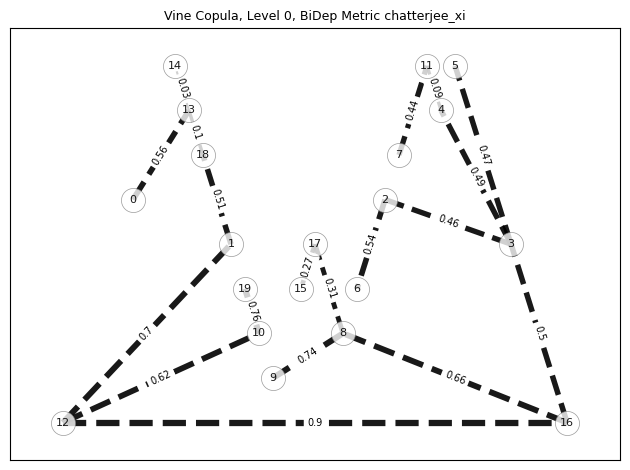

In [9]:
# SPY is vertex 12
mdl_vcp.draw_lv()

In [10]:
print(mdl_vcp.tpl_sim)
V_sim = mdl_vcp.sim(num_sim=NUM_SIM, device=DEVICE)
print(V_sim)

(5, 6, 7, 14, 0, 13, 15, 11, 17, 4, 2, 9, 3, 8, 16, 18, 1, 12, 10, 19)
tensor([[0.1972, 0.7794, 0.9398,  ..., 0.7229, 0.9267, 0.8805],
        [0.9863, 0.8067, 0.8147,  ..., 0.9695, 0.2992, 0.6501],
        [0.1837, 0.3703, 0.5817,  ..., 0.3942, 0.5793, 0.4968],
        ...,
        [0.7750, 0.6954, 0.9681,  ..., 0.4502, 0.2036, 0.9686],
        [0.1825, 0.1502, 0.2531,  ..., 0.3980, 0.3771, 0.1111],
        [0.7230, 0.3184, 0.7601,  ..., 0.4687, 0.2060, 0.3140]],
       device='cuda:0', dtype=torch.float64)


In [11]:
arr_sim = np.hstack([ppf(V_sim[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])])

print(arr_sim.min(), arr_sim.max())
print(
    "\nkendall tau wrt SPY, of simulations",
    pd.DataFrame(arr_sim, columns=df_retn_adjclose_simple_last_intvl.columns).corr(
        method="kendall"
    )["SPY"],
)
print(
    "\nkendall tau wrt SPY, of raw obs",
    df_retn_adjclose_simple_last_intvl.corr(method="kendall")["SPY"],
)

-0.25981756964804775 0.3198843992162125

kendall tau wrt SPY, of simulations Ticker
AGG   -0.088833
DIA    0.791133
EEM    0.555770
EFA    0.644702
EWA    0.559565
EWJ    0.506055
FXI    0.429651
GLD    0.039605
IJH    0.723841
IWM    0.670877
QQQ    0.734207
SLV    0.137552
SPY    1.000000
TLT   -0.215221
UNG    0.017274
USO    0.258027
VTI    0.931347
XLE    0.480362
XLF    0.653296
XLK    0.721068
Name: SPY, dtype: float64

kendall tau wrt SPY, of raw obs Ticker
AGG   -0.082133
DIA    0.794229
EEM    0.548927
EFA    0.645341
EWA    0.549117
EWJ    0.500938
FXI    0.429746
GLD    0.023180
IJH    0.724894
IWM    0.675022
QQQ    0.735662
SLV    0.128390
SPY    1.000000
TLT   -0.207960
UNG    0.038260
USO    0.233616
VTI    0.932040
XLE    0.466943
XLF    0.646061
XLK    0.724911
Name: SPY, dtype: float64


## rvine, cond sim
> make rvine from multivariate copula observations, **cond sim**

In [12]:
# user specify the priority vertices list, used in fitting and also in the conditional simulation
mdl_vcp_cond = tvc.vinecop.vcp_from_obs(
    V_mvcp,
    mtd_vine="rvine",
    tpl_first=(12,),
)

print(mdl_vcp_cond)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_603,
 'num_par': 119,
 'negloglik': -56397.2702,
 'aic': -112556.5404,
 'bic': -111819.9873,
 'matrix': '[[ 5 14  0 13 19 10 18  1  7  9 11 12 15 17  8 16  4  6  2  3]'
           ' [-1  6 14  0 13 19 10 18  1  7  9 11 12 15 17  8 16  4  3  2]'
           ' [-1 -1  7 14  0 13 19 10 18  1 15  9 12 17  8 16  2  3  4 11]'
           ' [-1 -1 -1 14 15 11 17  4  2  9 19  3  8 16 10 12  1  0 18 13]'
           ' [-1 -1 -1 -1  0 15 11 17  4  2  9 19  3  8 16 10 12  1 18 13]'
           ' [-1 -1 -1 -1 -1 13 15 11 17  4  2  9 19  3  8 16 10 12  1 18]'
           ' [-1 -1 -1 -1 -1 -1 15 19 10 18  1  9 11 12  4  2  3 16  8 17]'
           ' [-1 -1 -1 -1 -1 -1 -1 11 19 10 18  1  9 12 17  8 16  2  3  4]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 17 19 10 18  1  9 12  4  2  3 16  8]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1  4 19 10 18  1  9 12  8 16  2  3]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 19 10 18  1  9 12  8 16  3]'
          

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x235c073bac0>)

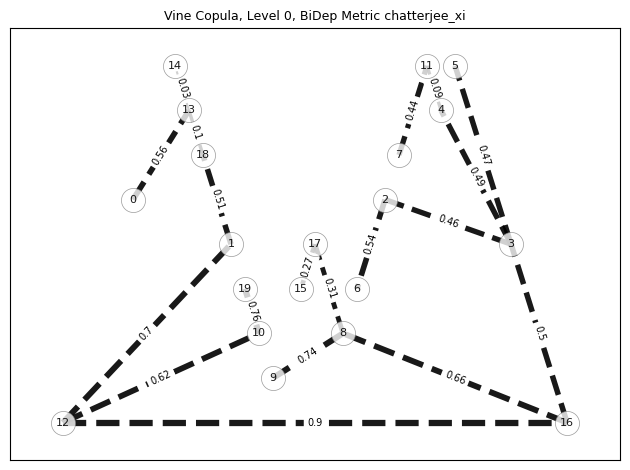

In [13]:
# SPY is vertex 12
mdl_vcp_cond.draw_lv()

In [14]:
# cond sim: user specified values for first set (vertex 12),
# a tail scenario with CDF(SPY)=.05
dct_first_vs = {(12, frozenset()): torch.ones(size=(NUM_SIM, 1), device=DEVICE) * (0.05)}
V_sim_cond = mdl_vcp.sim(num_sim=NUM_SIM, dct_first_vs=dct_first_vs, device=DEVICE)
arr_sim_cond = np.hstack(
    [ppf(V_sim_cond[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])]
)
print("specified value of SPY:", arr_sim_cond[:, 12])
print(arr_sim_cond[:3, :])

specified value of SPY: [-0.0172225 -0.0172225 -0.0172225 ... -0.0172225 -0.0172225 -0.0172225]
[[ 0.00416602 -0.02800842 -0.00599485 -0.03239967 -0.02308853 -0.02320681
  -0.00593737 -0.02074987 -0.01730058 -0.01036572  0.02069152 -0.09752218
  -0.0172225   0.05919974 -0.0060438  -0.04569908 -0.01330619 -0.02619925
  -0.11873297  0.01409716]
 [ 0.00527565 -0.017206   -0.00813661  0.00108865  0.00144725  0.01173167
  -0.00243986  0.0071394  -0.02597225 -0.02344728 -0.00641404 -0.00402832
  -0.0172225   0.01441995  0.00244147  0.02394928 -0.01670917 -0.02002044
  -0.02289861 -0.00779471]
 [ 0.00117521 -0.01911099 -0.00624521 -0.00923365 -0.00147919 -0.00680771
  -0.01786091  0.00337108 -0.02589806 -0.0327709  -0.00223135  0.00223343
  -0.0172225   0.00772976  0.01598842  0.00354801 -0.01826012 -0.00693108
  -0.03235149 -0.00044192]]
